In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Songs" data-toc-modified-id="Songs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Songs</a></span><ul class="toc-item"><li><span><a href="#song_length" data-toc-modified-id="song_length-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>song_length</a></span><ul class="toc-item"><li><span><a href="#more-on-song_length" data-toc-modified-id="more-on-song_length-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>more on song_length</a></span></li></ul></li><li><span><a href="#genre_ids" data-toc-modified-id="genre_ids-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>genre_ids</a></span></li><li><span><a href="#artist_name" data-toc-modified-id="artist_name-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>artist_name</a></span></li><li><span><a href="#composer" data-toc-modified-id="composer-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>composer</a></span></li><li><span><a href="#lyricist" data-toc-modified-id="lyricist-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>lyricist</a></span></li><li><span><a href="#language" data-toc-modified-id="language-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>language</a></span></li></ul></li></ul></div>

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
comb_df = train_df.append(test_df)
members_df = pd.read_csv('data/members.csv')
songs_df = pd.read_csv('data/songs.csv')
song_extra_info_df = pd.read_csv('data/song_extra_info.csv')

songs_df = songs_df.merge(song_extra_info_df, on='song_id', how='left')

train_df = train_df.merge(songs_df, on='song_id', how='left')
test_df = test_df.merge(songs_df, on='song_id', how='left')

train_df = train_df.merge(members_df, on='msno', how='left')
test_df = test_df.merge(members_df, on='msno', how='left')

# fill missing data to visualize
train_df.fillna('nan', inplace=True)
test_df.fillna('nan', inplace=True)

<a id='chapter_song'></a>
# Songs

## song_length

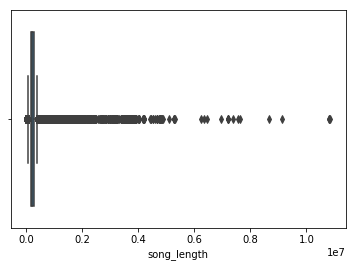

count      359914
mean       248419
std        146699
min          1393
25%        198217
50%        233732
75%        274746
max      10851706
Name: song_length, dtype: int64

In [3]:
song_length_unique_df = train_df[['song_id', 'song_length']].drop_duplicates('song_id')

song_length_unique_series = song_length_unique_df['song_length'].astype(np.float64)

# assert(song_length_unique_series.duplicates())
# print(song_length_unique_df)
sns.boxplot(x=song_length_unique_series)
plt.show()

song_length_unique_series.describe().astype(np.int64)

It seems that there exists outliers.
Now we treat them as outliers and so drop them.

In [4]:
song_length_unique_series = song_length_unique_series[np.abs(song_length_unique_series-song_length_unique_series.mean()) <= (3 * song_length_unique_series.std())]
song_length_unique_series.describe().astype(np.int64)

count    356821
mean     239738
std       78559
min        1393
25%      197903
50%      233128
75%      273438
max      688363
Name: song_length, dtype: int64

Notice that there exists very long song were played by users.

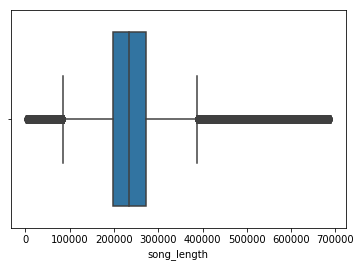

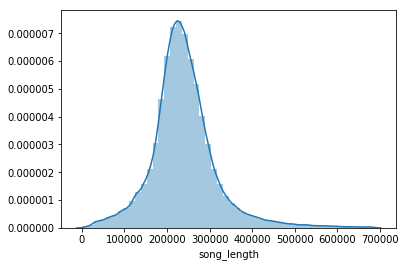

In [5]:
sns.boxplot(song_length_unique_series)
plt.show()

sns.distplot(song_length_unique_series)
plt.show()

It seems the distribution is almost normal after removing outliers.

### more on song_length

1393.0 10851706.0


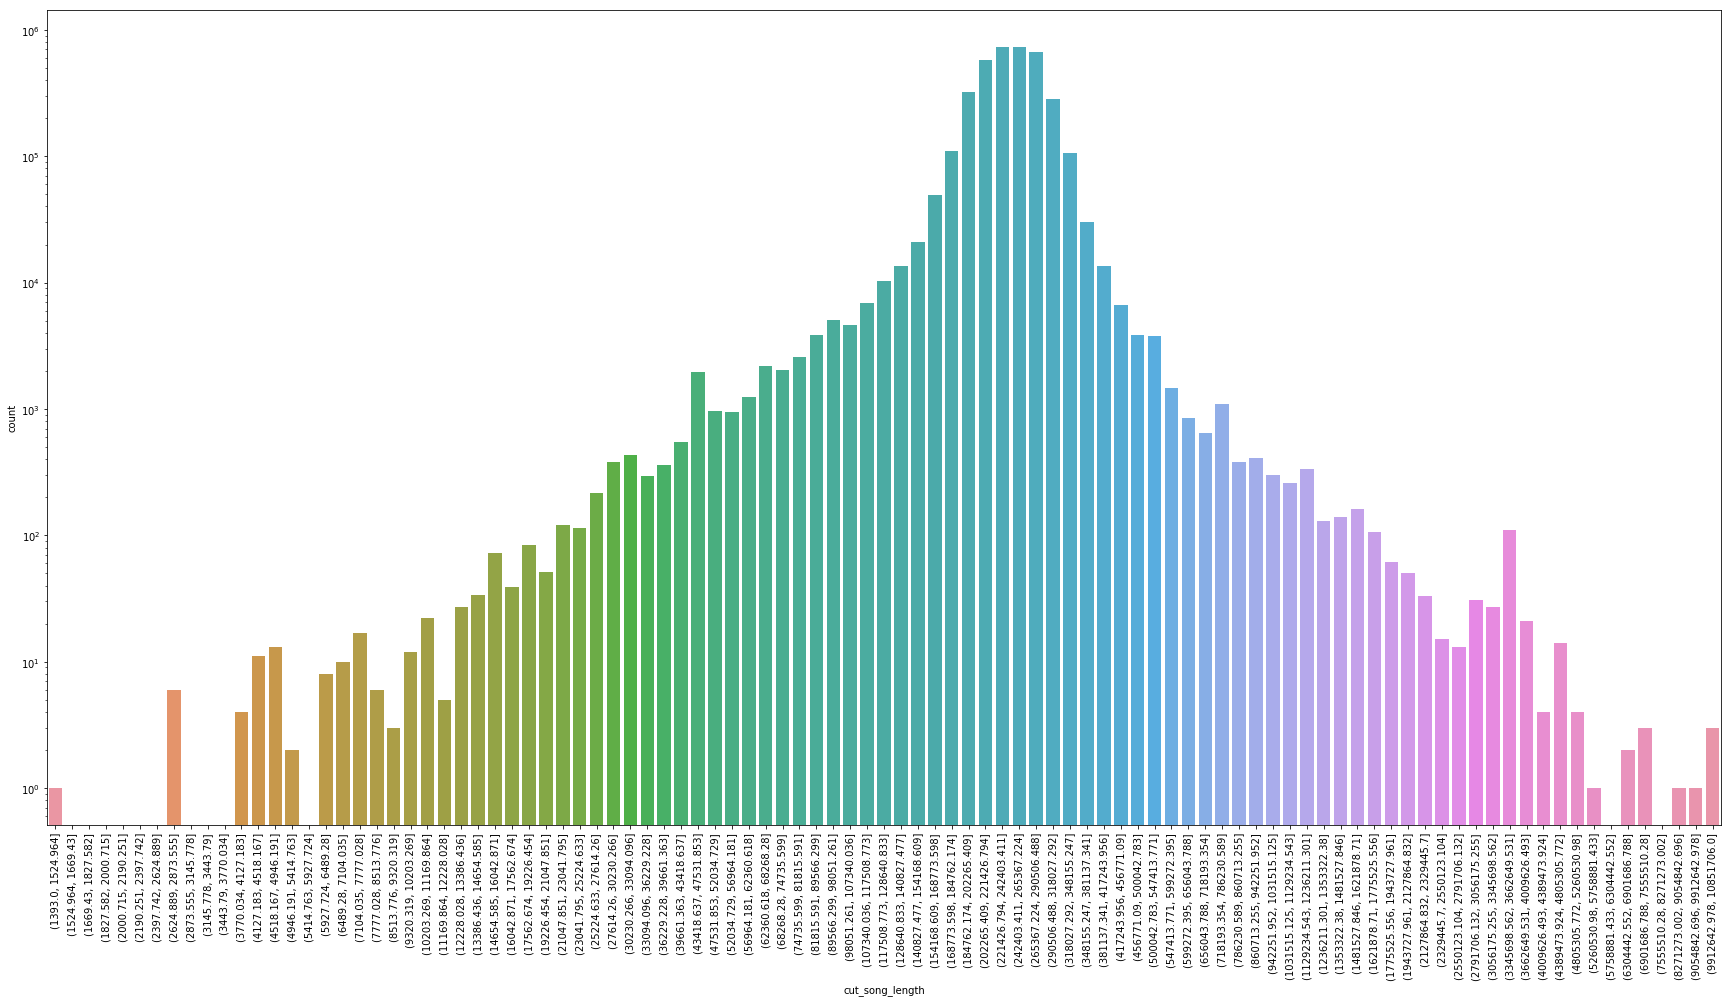

In [6]:
count_df = train_df[['song_length', 'target']]
count_df = count_df[count_df['target'] == 1]


# transform scale unit into "log10"
count_df['song_length'] = count_df['song_length'].astype(np.float64)
print(count_df['song_length'].min(), count_df['song_length'].max())
length_bins = np.logspace(np.log10(count_df['song_length'].min()), np.log10(count_df['song_length'].max()), 100)

# ignore missing data
count_df['song_length'].fillna(0.0, inplace=True)

count_df['cut_song_length'] = pd.cut(count_df['song_length'], bins=length_bins)
count_df.head(10)

plt.figure(figsize=(30, 15)) 
plt.xticks(rotation=90)
g = sns.countplot(x='cut_song_length', data=count_df)
g.set_yscale('log', nonposy='clip')
plt.show()

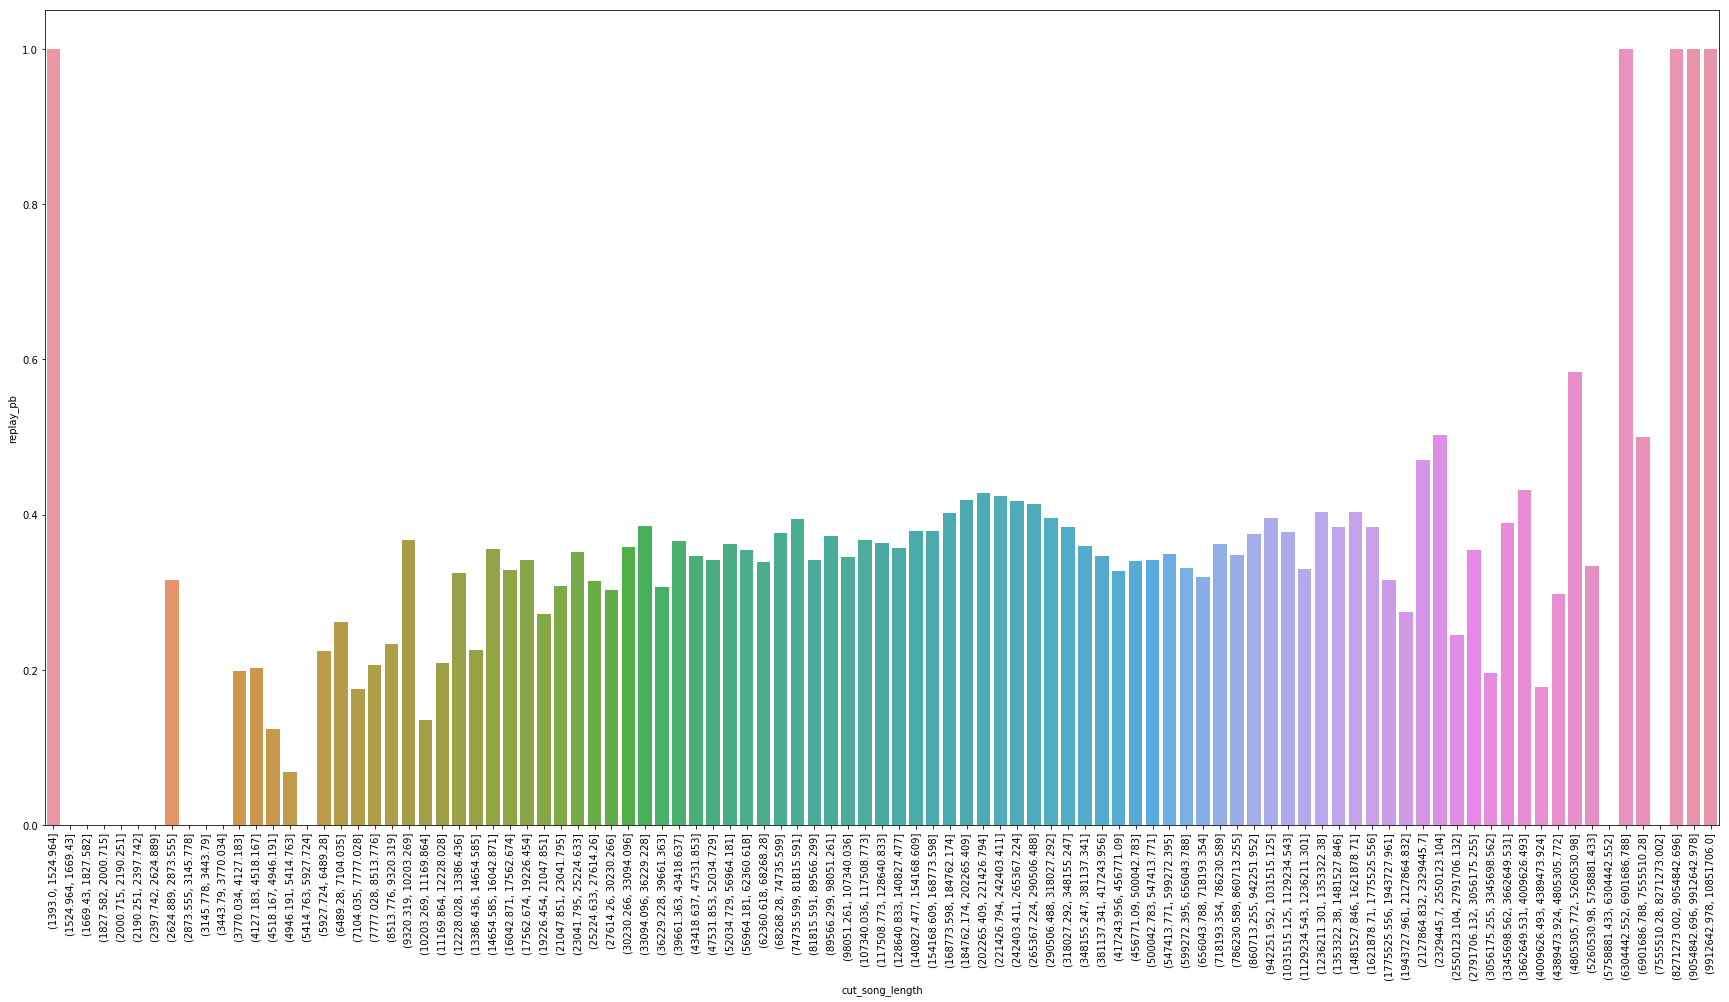

In [7]:
count_df = train_df[['song_length', 'target']].groupby('song_length').agg('mean')
count_df.reset_index(inplace=True)
count_df.columns = ['song_length', 'replay_pb']

# transform scale unit into "log10"
count_df['song_length'] = count_df['song_length'].astype(np.float64)
length_bins = np.logspace(np.log10(count_df['song_length'].min()), np.log10(count_df['song_length'].max()), 100)
count_df['song_length'].fillna(0.0, inplace=True)

count_df['cut_song_length'] = pd.cut(count_df['song_length'], bins=length_bins)


count_df = count_df[['cut_song_length', 'replay_pb']].groupby('cut_song_length').agg('mean')
count_df.reset_index(inplace=True)
count_df.head(10)

plt.figure(figsize=(30, 15)) 
plt.xticks(rotation=90)
sns.barplot(y='replay_pb', x='cut_song_length', data=count_df)
plt.show()

The songs whose song length larger than average one (248419 ms) have larger chance for replaying.
Maybe the longer songs are played from small users; but these users really like them.
也就是說，冷門的歌曲更會被其歌迷追蹤。

## genre_ids

In [8]:
song_genre_ids_series = train_df['genre_ids']
# print(list(song_genre_ids_series))

There are missing data and all seperators are only '|' sign.

In [9]:
def parse_splitted_category_to_number(x):
    if x is np.nan:
        return 0
    
    x = str(x)
    x.replace('/', '|')
    x.replace(';', '|')
    x.replace('\\', '|')
    x.replace('&', '|')
    return x.count('|') + 1


train_df['genre_count'] = train_df['genre_ids'].apply(parse_splitted_category_to_number)
genre_df = train_df[['song_id', 'genre_ids', 'genre_count', 'target']]

genre_df.head(10)

,song_id,genre_ids,genre_count,target
0,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,359,1,1
1,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,1259,1,1
2,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,1259,1,1
3,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,1019,1,1
4,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,1011,1,1
5,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,1259,1,1
6,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,465,1,1
7,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,1011,1,1
8,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,2022,1,1
9,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,465,1,1


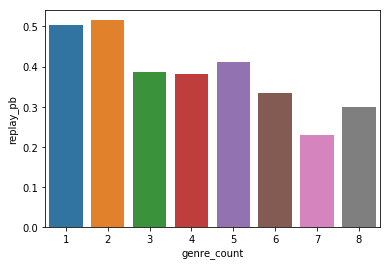

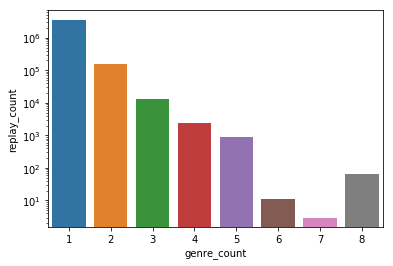

,genre_count,replay_pb,play_count,replay_count
0,1,0.503714,7037101,3544685
1,2,0.515374,298160,153664
2,3,0.386646,33682,13023
3,4,0.382546,6096,2332
4,5,0.411792,2120,873
5,6,0.333333,33,11
6,7,0.230769,13,3
7,8,0.300469,213,64


In [10]:
count_df = genre_df[['genre_count', 'target']].groupby('genre_count').agg(['mean', 'count'])
count_df.reset_index(inplace=True)
count_df.columns = ['genre_count', 'replay_pb', 'play_count']

count_df['replay_count'] = (count_df['replay_pb'] * count_df['play_count']).astype(np.int32)

sns.barplot(x='genre_count', y='replay_pb', data=count_df)
plt.show()

g = sns.barplot(x='genre_count', y='replay_count', data=count_df)
g.set_yscale('log', nonposy='clip')
plt.show()
count_df

**genre_ids** having 1 or 2 category is more chance to replay than more than 2 categories.
Replayed songs labeled single genre are more than others.

573


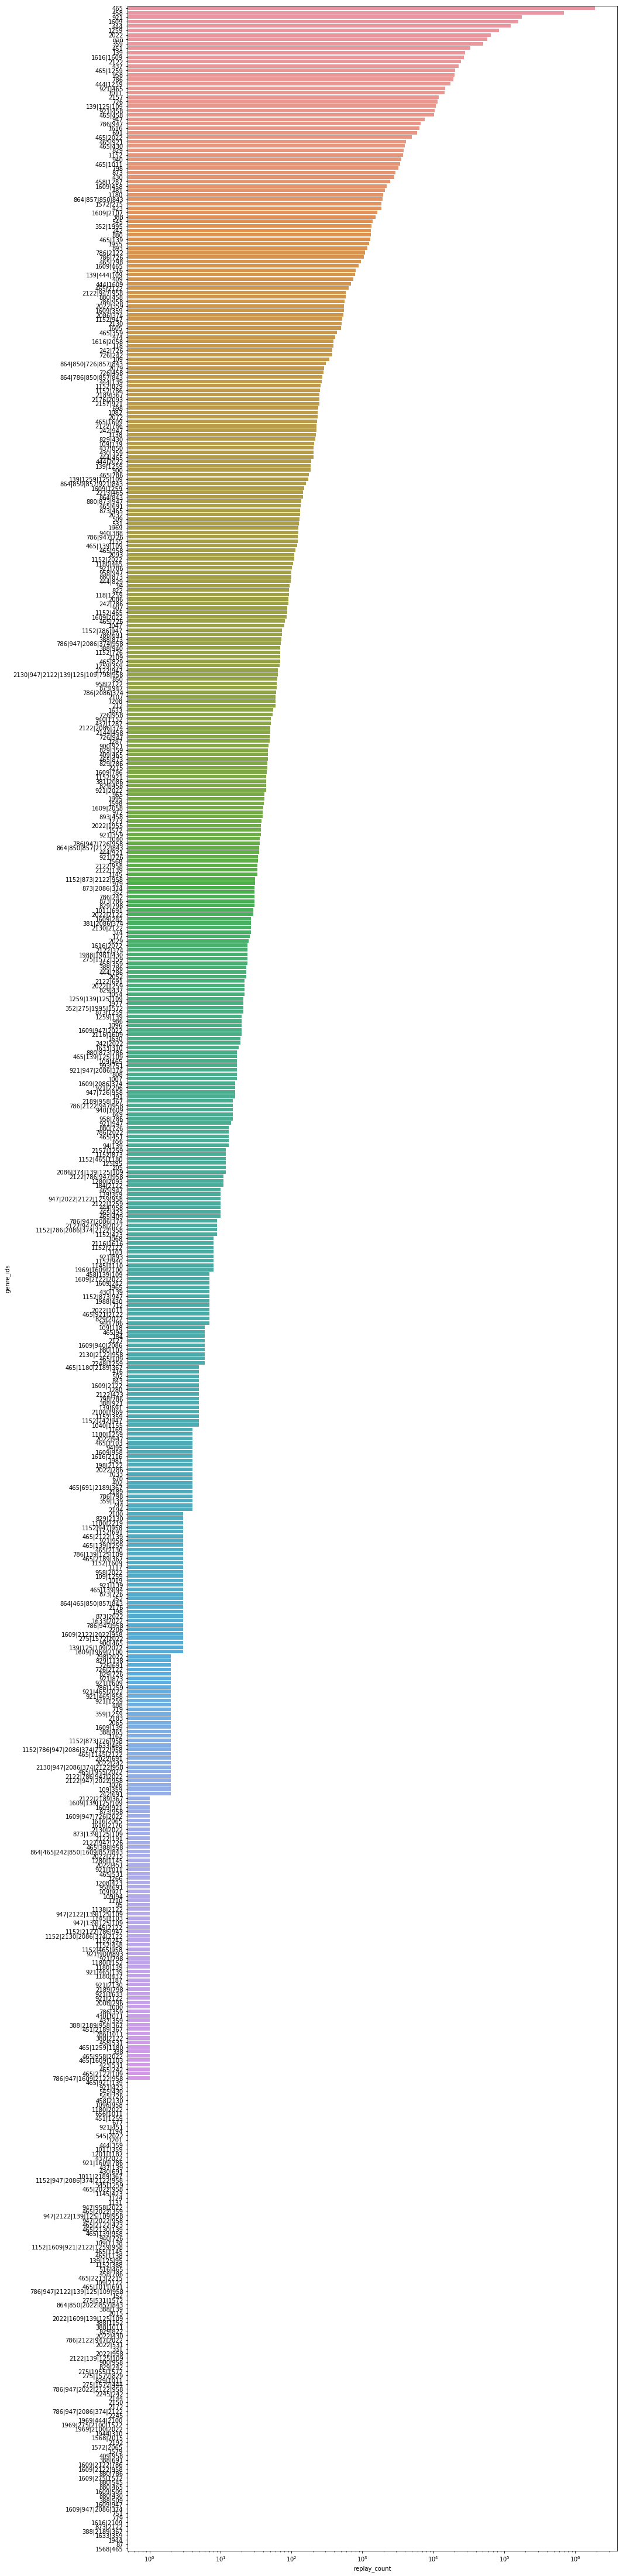

In [11]:
count_df = genre_df[['genre_ids', 'target']].groupby('genre_ids').agg(['mean', 'count'])
count_df.reset_index(inplace=True)
count_df.columns = ['genre_ids', 'replay_pb', 'play_count']
print(len(count_df))

count_df['replay_count'] = (count_df['replay_pb'] * count_df['play_count']).astype(np.int32)
count_df = count_df.sort_values(by=['replay_count'], ascending=False)

plt.figure(figsize=(15, 80))
g = sns.barplot(y='genre_ids', x='replay_count', data=count_df)
g.set_xscale('log', nonposx='clip')
plt.show()

There are total **573** combinations in *genre_ids*.
Notice that *genre 465* is the most popular; however, there is *genre 1568|465* which is the most unpopular where they both contain *genre 465*.
Hence, we can not decompose composite genres into several separate genres for consideration.

## artist_name

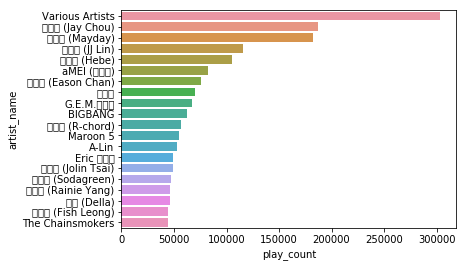

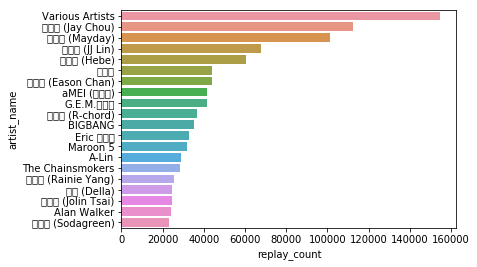

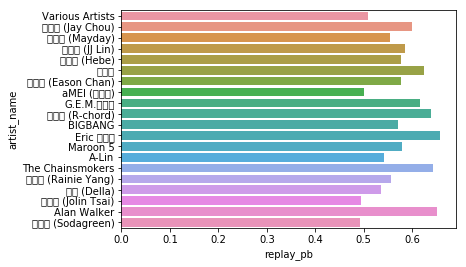

In [12]:
artist_df = train_df[['artist_name', 'target']].groupby('artist_name').agg(['mean', 'count']).reset_index()
artist_df.columns = ['artist_name', 'replay_pb', 'play_count']
# artist_df['artist_name'] = artist_df['artist_name'].apply(lambda x: x.decode('utf-8'))
artist_df['replay_count'] = (artist_df['replay_pb'] * artist_df['play_count']).astype(np.int32)
artist_df.head(15)

sns.barplot(y='artist_name', x='play_count', data=artist_df.sort_values(by=['play_count'], ascending=False).head(20))
plt.show()

sns.barplot(y='artist_name', x='replay_count', data=artist_df.sort_values(by=['replay_count'], ascending=False).head(20))
plt.show()

sns.barplot(y='artist_name', x='replay_pb', data=artist_df.sort_values(by=['replay_count'], ascending=False).head(20))
plt.show()

Many songs sung by Chinese artists are listend by users.

Furthermore, **Various Artist** means several artists; i.e., a song sung by composite singers is more popular.

## composer

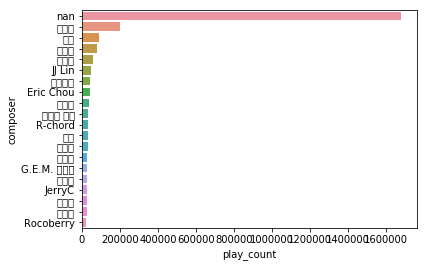

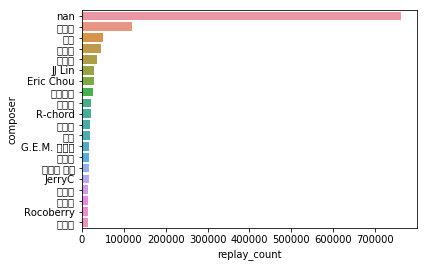

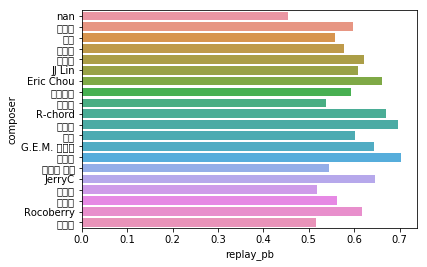

0.0054674475264
0.998519935437


,composer,replay_pb,play_count,replay_count
64876,nan,0.453613,1675706,760122
67156,周杰倫,0.597737,201910,120689
74068,阿信,0.557940,90343,50406
70043,林俊傑,0.577564,78606,45400
74543,陳皓宇,0.622618,58837,36633
27410,JJ Lin,0.609037,48089,29287
68783,張簡君偉,0.594053,43619,25912
19107,Eric Chou,0.661421,42832,28330
74820,韋禮安,0.538275,39621,21327
66348,八三夭 阿璞,0.545482,32782,17882


In [13]:
composer_df = train_df[['composer', 'target']].groupby('composer').agg(['mean', 'count']).reset_index()
composer_df.columns = ['composer', 'replay_pb', 'play_count']
composer_df['replay_count'] = (composer_df['replay_pb'] * composer_df['play_count']).astype(np.int32)


sns.barplot(y='composer', x='play_count', data=composer_df.sort_values(by=['play_count'], ascending=False).head(20))
plt.show()

sns.barplot(y='composer', x='replay_count', data=composer_df.sort_values(by=['replay_count'], ascending=False).head(20))
plt.show()

sns.barplot(y='composer', x='replay_pb', data=composer_df.sort_values(by=['replay_count'], ascending=False).head(20))
plt.show()

print(composer_df['play_count'].corr(composer_df['replay_pb']))
print(composer_df['play_count'].corr(composer_df['replay_count']))

composer_df.sort_values(by=['play_count'], ascending=False).head(15)

The more play counts, almost the more replay counts.
There are so so so many missing value.

## lyricist

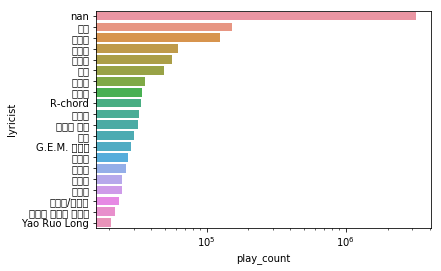

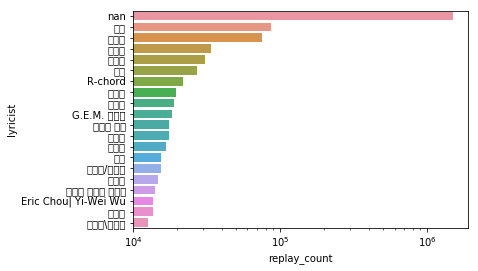

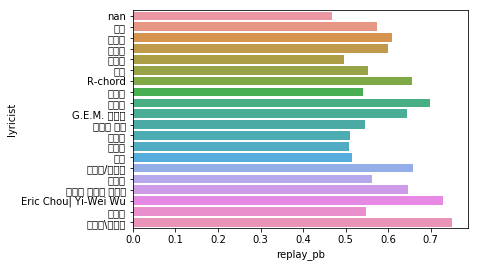

0.00410481273244
0.999761738532


,lyricist,replay_pb,play_count,replay_count
22883,nan,0.468265,3178797,1488518
32090,阿信,0.573532,151301,86776
27177,方文山,0.608124,124108,75473
25567,姚若龍,0.495160,62190,30794
25069,周杰倫,0.600249,56235,33755
28101,林夕,0.552081,49279,27205
32867,韋禮安,0.541291,36291,19644
24958,吳青峰,0.509086,34503,17565
17329,R-chord,0.655580,33613,22036
30709,葛大為,0.508900,32867,16726


In [14]:
lyricist_df = train_df[['lyricist', 'target']].groupby('lyricist').agg(['mean', 'count']).reset_index()
lyricist_df.columns = ['lyricist', 'replay_pb', 'play_count']
lyricist_df['replay_count'] = (lyricist_df['replay_pb'] * lyricist_df['play_count']).astype(np.int32)


g = sns.barplot(y='lyricist', x='play_count', data=lyricist_df.sort_values(by=['play_count'], ascending=False).head(20))
g.set_xscale('log', nonposx='clip')
plt.show()

g = sns.barplot(y='lyricist', x='replay_count', data=lyricist_df.sort_values(by=['replay_count'], ascending=False).head(20))
g.set_xscale('log', nonposx='clip')
plt.show()

sns.barplot(y='lyricist', x='replay_pb', data=lyricist_df.sort_values(by=['replay_count'], ascending=False).head(20))
plt.show()

print(lyricist_df['play_count'].corr(lyricist_df['replay_pb']))
print(lyricist_df['play_count'].corr(lyricist_df['replay_count']))

lyricist_df.sort_values(by=['play_count'], ascending=False).head(15)

The more play counts, almost the more replay counts.
There are so so so many missing value.

## language

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
language        11 non-null object
replay_pb       11 non-null float64
play_count      11 non-null int64
replay_count    11 non-null int32
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 388.0+ bytes
None


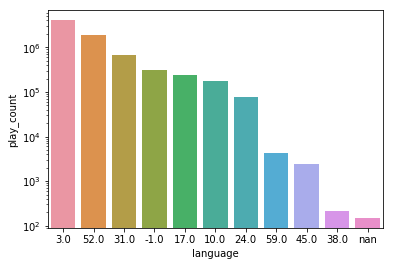

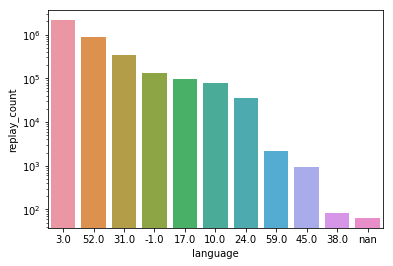

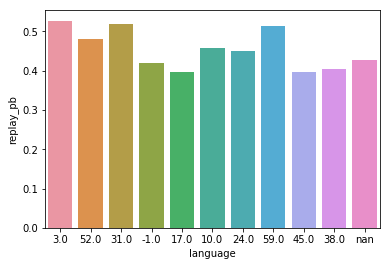

0.594590745427
0.589400972603
0.999226932777


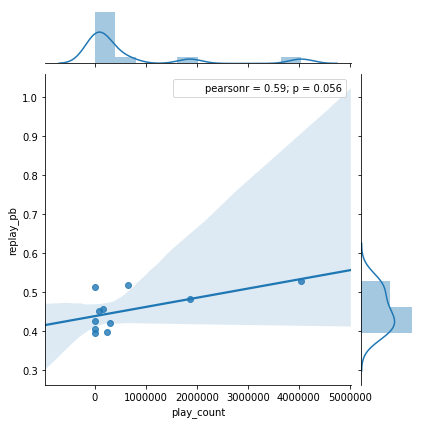

,language,replay_pb,play_count,replay_count
1,3,0.527132,4044643,2132059
8,52,0.481398,1864789,897706
5,31,0.519111,656623,340860
0,-1,0.419890,308752,129642
3,17,0.396453,245136,97185
2,10,0.456644,171904,78499
4,24,0.450948,78621,35454
9,59,0.513475,4193,2153
7,45,0.395912,2397,949
6,38,0.404762,210,85


In [15]:
language_df = train_df[['language', 'target']].groupby('language').agg(['mean', 'count']).reset_index()
language_df.columns = ['language', 'replay_pb', 'play_count']
language_df['replay_count'] = (language_df['replay_pb'] * language_df['play_count']).astype(np.int32)

print(language_df.info())
g = sns.barplot(x='language', y='play_count', data=language_df.sort_values(by=['play_count'], ascending=False))
g.set_yscale('log', nonposy='clip')
plt.show()

g = sns.barplot(x='language', y='replay_count', data=language_df.sort_values(by=['replay_count'], ascending=False))
g.set_yscale('log', nonposy='clip')
plt.show()

sns.barplot(x='language', y='replay_pb', data=language_df.sort_values(by=['replay_count'], ascending=False))
plt.show()

print(language_df['replay_count'].corr(language_df['replay_pb']))
print(language_df['play_count'].corr(language_df['replay_pb']))
print(language_df['play_count'].corr(language_df['replay_count']))

g = sns.jointplot(x="play_count", y="replay_pb", data=language_df, kind="reg")
plt.show()
language_df.sort_values(by=['play_count'], ascending=False)

We have correlation **0.59** between *replay_pb* and *play_count*.

- The language <font color='red'> 3 </font> is the most popular trivially. The language 59 has not enough samples.
- The languages <font color='red'> -1, 37, 45 </font> are rather unpopular. The language 38 has not enough samples.